In [ ]:
%%capture
!pip install fastai --upgrade

In [ ]:
from matplotlib import pyplot as plt
import numpy
from fastai.vision.all import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Train a U-Net model

## Load the data

In [ ]:
%%capture
!unzip "drive/My Drive/Omdena/Data/landcovernet/landcovernet_final.zip" # load the clean data

In [ ]:
path = Path('landcovernet_final')

In [ ]:
path_img = path/'inputs'
path_lbl = path/'targets'

In [ ]:
fnames = get_image_files(path_img)

In [ ]:
get_y_fn = lambda x: path_lbl/f'{re.findall(r"(.*2018)[0-9]+_RGB", x.stem)[0]}_LC_10m.png'

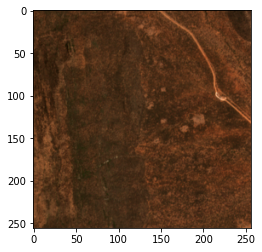

In [ ]:
plt.imshow(plt.imread(fnames[15]))

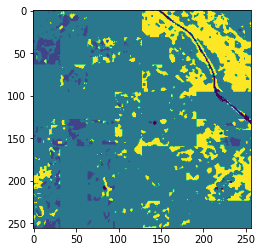

In [ ]:
plt.imshow(plt.imread(get_y_fn(fnames[15])))

These are the classes of landcovernet:

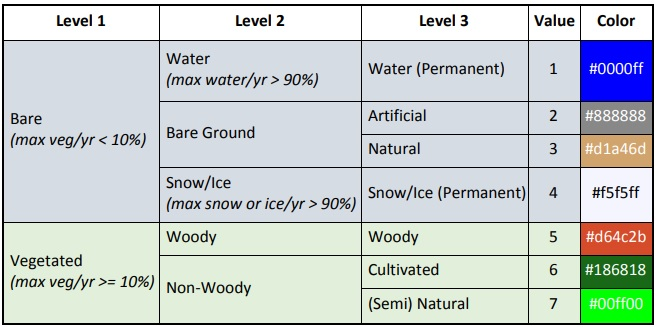

In [ ]:
codes = np.array(['Unknown', # first value always corresponds to 0
                  'Water', 
                  'Artificial ground',
                  'Bare soil',
                  'Snow/Ice',
                  'Woody vegetation',
                  'Cultivated vegetation'
                  'Natural vegetation'])

# Create a datablock and dataloaders

In [ ]:
lcn = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                get_items = get_image_files,
                get_y = get_y_fn,
                splitter = RandomSplitter(valid_pct=0.1),
                item_tfms = RandomResizedCrop(224, min_scale=0.35),
                batch_tfms = Normalize.from_stats(*imagenet_stats))

In [ ]:
lcn.summary(path_img)

Setting-up type transforms pipelines
Found 2512 items
2 datasets of sizes 2261,251
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      landcovernet_final/inputs/38PKQ_02_20180101_RGB.png
    applying PILBase.create gives
      PILImage mode=RGB size=256x256
  Pipeline: <lambda> -> PILBase.create
    starting from
      landcovernet_final/inputs/38PKQ_02_20180101_RGB.png
    applying <lambda> gives
      landcovernet_final/targets/38PKQ_02_2018_LC_10m.png
    applying PILBase.create gives
      PILMask mode=L size=256x256

Final sample: (PILImage mode=RGB size=256x256, PILMask mode=L size=256x256)


Found 2512 items
2 datasets of sizes 2261,251
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create
Setting up after_item: Pipeline: AddMaskCodes -> RandomResizedCrop -- {'size': (224, 224), 'min_scale': 0.35, 'ratio': (0.75, 1.3333333333333333), 'resamples': 

In [ ]:
dls = lcn.dataloaders(source=path_img, path=path, bs=8)

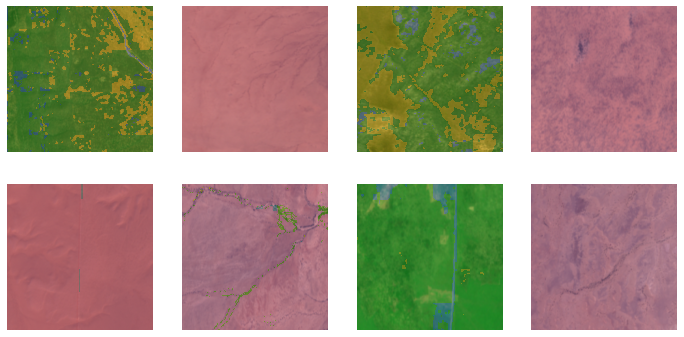

In [ ]:
dls.show_batch()

In [ ]:
def segm_acc(input, target) :
  target = target.squeeze(1)
  return (input.argmax(dim=1)==torch.tensor(target)).float().mean()

In [ ]:
learn = unet_learner(dls, resnet34, metrics=segm_acc)

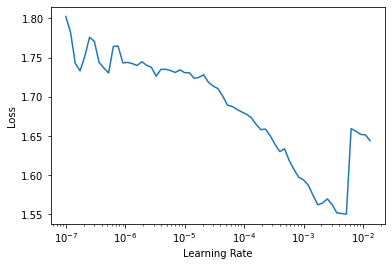

In [ ]:
lr_min, lr_steep = learn.lr_find()

In [ ]:
lr_min, lr_steep

(0.0005248074419796466, 7.585775847473997e-07)

In [ ]:
learn.fit_one_cycle(3, lr_max=lr_min)

epoch,train_loss,valid_loss,segm_acc,time
0,1.170141,1.191286,0.536616,00:58
1,1.055760,1.045525,0.587377,00:58
2,0.941465,0.939859,0.622085,00:58


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
learn.unfreeze()

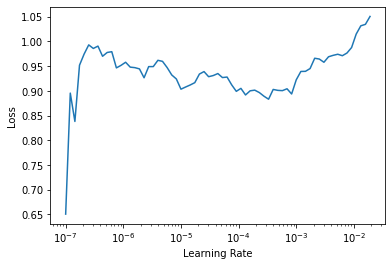

In [ ]:
lr_min, lr_steep = learn.lr_find()

In [ ]:
lr_min, lr_steep

(3.311311302240938e-05, 6.309573450380412e-07)

In [ ]:
learn.fit_one_cycle(12, lr_max=slice(lr_steep, lr_min))

epoch,train_loss,valid_loss,segm_acc,time
0,0.911266,0.945518,0.625459,01:01
1,0.839196,0.874398,0.654742,01:01
2,0.856760,0.836146,0.669004,01:01
3,0.777927,0.798003,0.681849,01:01
4,0.789303,0.740834,0.712943,01:01
5,0.733343,0.702737,0.720353,01:01
6,0.738332,0.704031,0.722329,01:01
7,0.706330,0.732261,0.707099,01:01
8,0.681764,0.683748,0.731308,01:01
9,0.677887,0.663092,0.739759,01:01


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


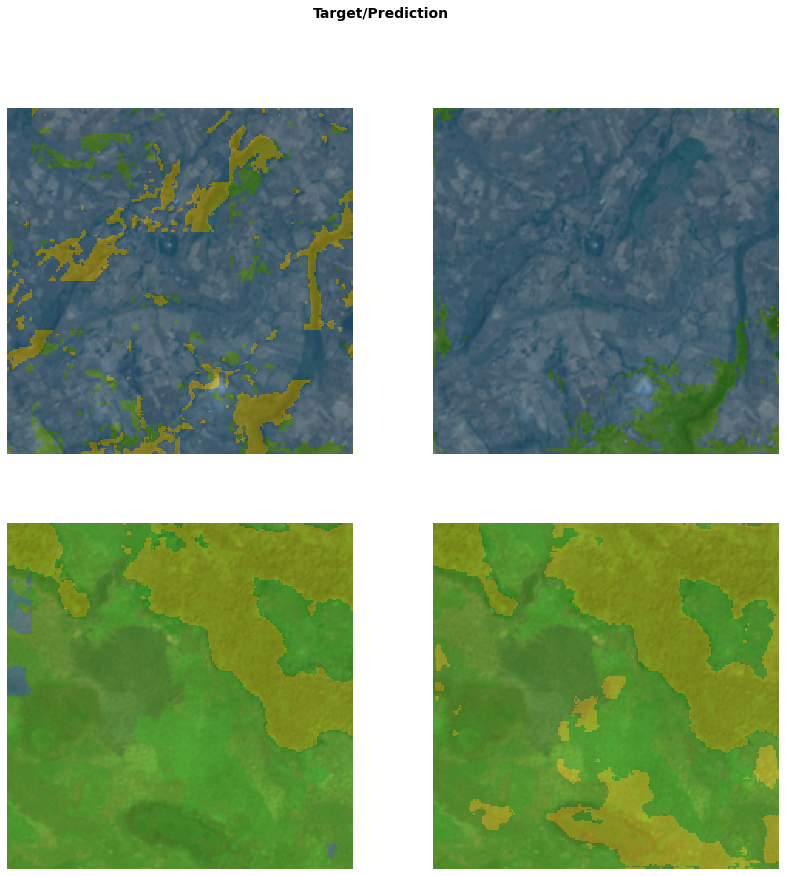

In [ ]:
learn.show_results(max_n=12, figsize=(14,14))